#**ANALISIS SENTIMEN APLIKASI GETCONTACT MENGGUNAKAN METODE RANDOM FOREST DENGAN EKSTRAKSI FITUR WORD2VEC**

Dataset berisi 1000 ulasan pengguna aplikasi Getcontact yang diambil dari Google Play Store. Data tersebut dikumpulkan melalui proses scraping menggunakan Python, dan setiap ulasan telah diterjemahkan ke dalam bahasa Inggris untuk memudahkan proses analisis sentimen.
Dataset ini bisa diakses dan didownload dari Kaggle,

link: https://www.kaggle.com/datasets/fajarsetiawan37/dataset-getcontact-app-reviews?resource=download



##Memuat Dataset

In [1]:
import pandas as pd

# memuat dataset
file_path = 'vader_analyzed_reviews_1000_new.xlsx'
df = pd.read_excel(file_path)

# melihat beberapa baris pertama dari dataset
df.head()

,content,sentiment
0,Saya kecewa setelah ada fitur tidak dpt menamp...,Negative
1,Aplikasi lelet minta ampun... Susah di jadikan...,Negative
2,"Setelah update, tidak bisa digunakan lagi. Set...",Negative
3,"Aplikasinya bagus, manfaatnya bagus, fiturnya ...",Positive
4,"Dengan adanya Aplikasi Getcontact, bisa memban...",Positive


##Tahap Preprocessing

In [2]:
import pandas as pd
import re
import nltk
import json
from nltk.tokenize import word_tokenize
from Sastrawi.Stemmer.StemmerFactory import StemmerFactory

# mengunduh model NLTK
nltk.download('punkt')

# inisialisasi Indonesian stemmer
factory = StemmerFactory()
stemmer = factory.create_stemmer()

# fungsi untuk memuat kamus slangwords
def load_slang_dictionary(filepath):
    with open(filepath, 'r', encoding='utf-8') as file:
        slang_json = file.read()
        slang_dict = json.loads(slang_json)
    return slang_dict

# fungsi untuk memuat kamus stopwords
def load_stop_words(filepath):
    with open(filepath, 'r', encoding='utf-8') as file:
        stop_words = set(file.read().splitlines())
    return stop_words

# fungsi untuk mengganti kata slang pada teks
def replace_slang(text, slang_dict):
    words = text.split()
    replaced_words = [slang_dict.get(word, word) for word in words]
    return ' '.join(replaced_words)

# fungsi pre-processing
def preprocess_text(text, slang_dict, stop_words_custom):
    # Case folding
    case_folded = text.lower()

    # Remove punctuation
    no_punctuation = re.sub(r'[^\w\s]', '', case_folded)
    no_punctuation = re.sub(r'\d+', '', no_punctuation)

    # Replace slang words (Normalization)
    normalized = replace_slang(no_punctuation, slang_dict)

    # Tokenizing (split into words)
    tokens = normalized.split()

    # Stopword removal
    tokens_no_stopwords = [word for word in tokens if word not in stop_words_custom]

    # Stemming
    stemmed_tokens = [stemmer.stem(word) for word in tokens_no_stopwords]

    # menggabungkan token yang telah di-stem menjadi satu string tunggal yang disebut "Cleaned Text"
    cleaned_text = ' '.join(stemmed_tokens)

    return case_folded, no_punctuation, normalized, tokens, tokens_no_stopwords, stemmed_tokens, cleaned_text

# memuat kamus slang words dan stop words
slang_dict = load_slang_dictionary('combined_slang_words.txt')
stop_words_custom = load_stop_words('combined_stop_words.txt')

# mengaplikasikan fungsi preprocessing dan membagi hasil kedalam kolom terpisah
results = df['content'].apply(lambda text: preprocess_text(text, slang_dict, stop_words_custom))
df[['case_folded', 'no_punctuation', 'normalized', 'tokenized', 'tokens_no_stopwords', 'stemmed_tokens', 'cleaned_text']] = pd.DataFrame(results.tolist(), index=df.index)

# simpan DataFrame menjadi file CSV
df.to_csv('processed_reviews_detailed.csv', index=False, columns=['content', 'case_folded', 'no_punctuation', 'normalized', 'tokenized', 'tokens_no_stopwords', 'stemmed_tokens', 'cleaned_text'])

# tampilkan pesan ketika selesai
print("The detailed processed reviews have been saved to 'processed_reviews_detailed.csv'.")

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\User\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


The detailed processed reviews have been saved to 'processed_reviews_detailed.csv'.


##Splitting Data

In [3]:
# bagi DataFrame untuk testing dan training

df_testing = df.iloc[800:1000]
df_training = df.iloc[:800]

# simpan testing dan training data ke file CSV terpisah
df_testing.to_csv('testing_data.csv', index=False)
df_training.to_csv('training_data.csv', index=False)

# tampilkan pesan ketika selesai
print("Testing data saved to 'testing_data.csv'.")
print("Training data saved to 'training_data.csv'.")

Testing data saved to 'testing_data.csv'.
Training data saved to 'training_data.csv'.


In [4]:
print(df.columns)

Index(['content', 'sentiment', 'case_folded', 'no_punctuation', 'normalized',
       'tokenized', 'tokens_no_stopwords', 'stemmed_tokens', 'cleaned_text'],
      dtype='object')


Code tersebut diperuntukkan untuk mengecek nama-nama kolom yang terdapat pada dataset.

##Ekstraksi Fitur Menggunakan Word2Vec dan Klasifikasi Menggunakan Random Forest

In [5]:
import pandas as pd
from gensim.models import Word2Vec
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report

# memuat data pelatihan dan pengujian dari file CSV
df_training = pd.read_csv('training_data.csv')
df_testing = pd.read_csv('testing_data.csv')

# tokenisasi pada teks yang telah dibersihkan dari data pelatihan
tokenized_text = [text.split() for text in df_training['cleaned_text']]

# melatih model Word2Vec pada data pelatihan yang telah ditokenisasi
model = Word2Vec(tokenized_text, vector_size=100, window=5, min_count=1, workers=4, sg=1, epochs=20)

# fungsi untuk mendapatkan embedding kalimat dari model Word2Vec
def get_sentence_embedding(text):
    tokens = text.split()
    vectors = [model.wv[word] for word in tokens if word in model.wv]
    if vectors:
        return sum(vectors) / len(vectors)
    else:
        return [0] * 100  # Return a zero vector if no words are found in the vocabulary

# menerapkan fungsi get_sentence_embedding yang telah dibuat ke data pelatihan dan pengujian
df_training['embedding'] = df_training['cleaned_text'].apply(get_sentence_embedding)
df_testing['embedding'] = df_testing['cleaned_text'].apply(get_sentence_embedding)

# memperluas setiap embedding yang diperoleh dari model Word2Vec menjadi kolomnya masing-masing dalam DataFrame
for i in range(100):
    df_training[f'embedding_{i+1}'] = df_training['embedding'].apply(lambda x: x[i])
    df_testing[f'embedding_{i+1}'] = df_testing['embedding'].apply(lambda x: x[i])

# Menampilkan 5 baris pertama dari DataFrame pelatihan untuk melihat embedding yang diperoleh
print("Training Data - First 5 Entries with Embeddings:")
print(df_training[['cleaned_text'] + [f'embedding_{i+1}' for i in range(100)]].head())

# Menampilkan 5 baris pertama dari DataFrame pengujian untuk melihat embedding yang diperoleh
print("Testing Data - First 5 Entries with Embeddings:")
print(df_testing[['cleaned_text'] + [f'embedding_{i+1}' for i in range(100)]].head())

# menghapus kolom 'embedding' dari DataFrame pelatihan
df_training.drop(columns=['embedding'], inplace=True)
# menghapus kolom 'embedding' dari DataFrame pengujian
df_testing.drop(columns=['embedding'], inplace=True)

# menyiapkan fitur (X) dan label (y) untuk model pembelajaran mesin
X_train = df_training[[f'embedding_{i+1}' for i in range(100)]]
y_train = df_training['sentiment']

X_test = df_testing[[f'embedding_{i+1}' for i in range(100)]]
y_test = df_testing['sentiment']

# inisialiasi Random Forest classifier
rf_classifier = RandomForestClassifier(n_estimators=100, random_state=42)

# melatih model menggunakan data latih
rf_classifier.fit(X_train, y_train)

# membuat prediksi pada data pengujian
y_pred = rf_classifier.predict(X_test)

# evaluasi model
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)
print("\nClassification Report:")
print(classification_report(y_test, y_pred))

# menambahkan sentimen yang diprediksi dan aktual ke DataFrame pengujian
df_testing['predicted_sentiment'] = y_pred
df_testing['actual_sentiment'] = y_test

# menentukan kolom yang akan disimpan
columns_to_save = ['cleaned_text'] + [f'embedding_{i+1}' for i in range(100)] + ['actual_sentiment', 'predicted_sentiment']
# menyimpan DataFrame ke file CSV
df_testing[columns_to_save].to_csv('testing_results_with_embeddings.csv', index=False)

C:\Users\User\AppData\Local\Temp\ipykernel_12804\2917092983.py:31: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_training[f'embedding_{i+1}'] = df_training['embedding'].apply(lambda x: x[i])
C:\Users\User\AppData\Local\Temp\ipykernel_12804\2917092983.py:32: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_testing[f'embedding_{i+1}'] = df_testing['embedding'].apply(lambda x: x[i])
C:\Users\User\AppData\Local\Temp\ipykernel_12804\2917092983.py:31: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result o

Training Data - First 5 Entries with Embeddings:
                                        cleaned_text  embedding_1  \
0  kecewa ada fitur tidak tampil guna barusan ada...    -0.194690   
1  aplikasi lama ampun sulit jadi default aplikas...    -0.010401   
2  update tidak bisa guna buka muncul pesan inter...    -0.022902   
3  aplikasi bagus manfaat bagus fiturnya bagus ta...    -0.122808   
4  aplikasi getcontact bisa bantu jawab penasaran...    -0.177575   

   embedding_2  embedding_3  embedding_4  embedding_5  embedding_6  \
0     0.089409    -0.013698     0.122359     0.030322    -0.244186   
1     0.164354    -0.107837    -0.065992     0.192631    -0.263355   
2     0.167768    -0.071771    -0.039936     0.164412    -0.244962   
3     0.145747    -0.017606     0.062277     0.084504    -0.227910   
4     0.152985    -0.017156     0.057959     0.043712    -0.219887   

   embedding_7  embedding_8  embedding_9  ...  embedding_91  embedding_92  \
0     0.122280     0.285766    -0.2057

Jumlah prediksi benar: 174
Jumlah prediksi salah: 26


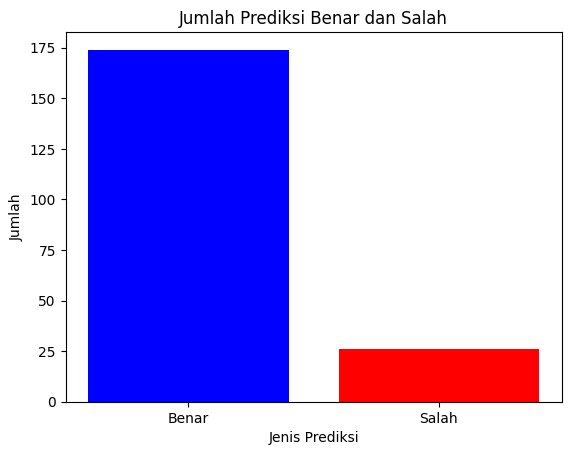

In [6]:
# Menambahkan kolom 'correct' untuk menandai prediksi benar atau salah
df_testing['correct'] = df_testing['predicted_sentiment'] == df_testing['actual_sentiment']

# Menghitung jumlah prediksi benar dan salah
correct_count = df_testing['correct'].sum()
incorrect_count = len(df_testing) - correct_count

print(f"Jumlah prediksi benar: {correct_count}")
print(f"Jumlah prediksi salah: {incorrect_count}")
import matplotlib.pyplot as plt

# Data untuk bar chart
labels = ['Benar', 'Salah']
counts = [correct_count, incorrect_count]

# Membuat bar chart
plt.bar(labels, counts, color=['blue', 'red'])
plt.title('Jumlah Prediksi Benar dan Salah')
plt.xlabel('Jenis Prediksi')
plt.ylabel('Jumlah')
plt.show()

##Memisahkan hasil yang cocok dan tidak cocok dari prediksi model

In [7]:
# memfilter baris di mana sentimen aktual berbeda dari sentimen yang diprediksi dalam DataFrame
mismatch_df = df_testing[df_testing['actual_sentiment'] != df_testing['predicted_sentiment']]

# memfilter baris di mana sentimen aktual sesuai dengan sentimen yang diprediksi dalam DataFrame
matches_df = df_testing[df_testing['actual_sentiment'] == df_testing['predicted_sentiment']]

# menyimpan hasil ketidakcocokan (mismatched results) ke dalam file CSV
mismatch_columns = ['content'] + ['cleaned_text'] + ['actual_sentiment', 'predicted_sentiment']
mismatch_df[mismatch_columns].to_csv('mismatched_sentiments.csv', index=False)

# menyimpan hasil yang cocok (matched results) ke dalam file CSV
matched_columns = ['content'] + ['cleaned_text'] + ['actual_sentiment', 'predicted_sentiment']
matches_df[matched_columns].to_csv('matched_sentiments.csv', index=False)

# menampilkan pesan ketika selesai
print("Testing data mismathed saved to 'mismatched_sentiments.csv'.")
print("Testing data matched saved to 'matched_sentiments.csv'.")

Testing data mismathed saved to 'mismatched_sentiments.csv'.
Testing data matched saved to 'matched_sentiments.csv'.


 ##Menganalisis data yang tidak cocok dalam hasil prediksi model sentimen

In [8]:
# memuat data
mismatched_data = pd.read_csv('mismatched_sentiments.csv')

# tampilkan informasi dasar dan beberapa baris pertama untuk mendapatkan gambaran data
print(mismatched_data.info())
print(mismatched_data.head())

# periksa kata-kata umum dalam entri yang tidak cocok
from collections import Counter
all_words = Counter(" ".join(mismatched_data['cleaned_text']).split())
common_words = all_words.most_common(10)
print("Kata-kata umum dalam teks yang tidak cocok:", common_words)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 26 entries, 0 to 25
Data columns (total 4 columns):
 #   Column               Non-Null Count  Dtype 
---  ------               --------------  ----- 
 0   content              26 non-null     object
 1   cleaned_text         26 non-null     object
 2   actual_sentiment     26 non-null     object
 3   predicted_sentiment  26 non-null     object
dtypes: object(4)
memory usage: 964.0+ bytes
None
                                             content  \
0  Seharusnya saya kasih bintang lima tapi karena...   
1                  Sangat baik jaringannya luarbiasa   
2      kontakku bnyak, tpi yg dikasih liat cmn dikit   
3  Sejauh ini bagus sih .cmn KL mau liat Tag haru...   
4                   Versi gratis nya perpanjang dong   

                                        cleaned_text actual_sentiment  \
0  harus kasih bintang tapi karena get contact te...         Negative   
1                           sangat baik jaring bagus         Positive  

##Melakukan evaluasi menggunakan Confussion Matrix


Confusion Matrix:
[[77 13]
 [13 97]]


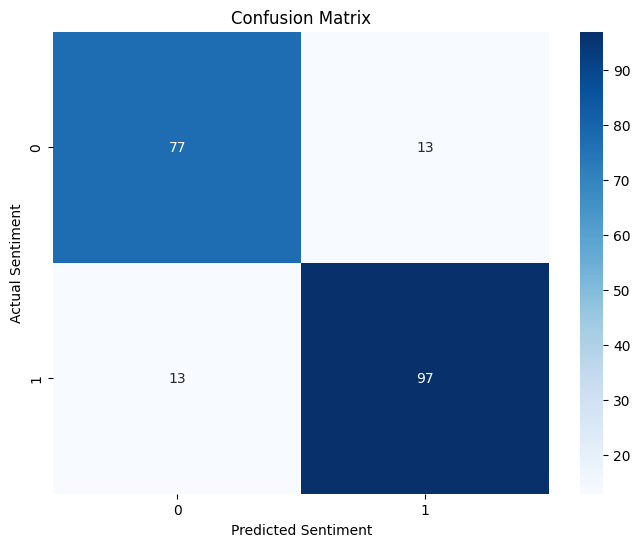

In [9]:
import pandas as pd
import numpy as np
from gensim.models import Word2Vec
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# menghitung confusion matrix
cm = confusion_matrix(y_test, y_pred)
print("\nConfusion Matrix:")
print(cm)

# memplot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix')
plt.ylabel('Actual Sentiment')
plt.xlabel('Predicted Sentiment')
plt.show()